# 多层全连接神经网络

## 1 线性模型

### 1.1 一维线性回归

In [1]:
import torch
import numpy as np
from torch import nn, optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

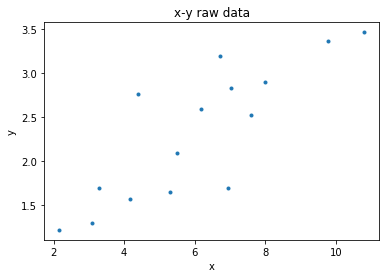

In [2]:
# 1.创建数据
x_train = np.array([3.3, 4.4, 5.5, 6.71, 6.93, 4.168, 9.779, 6.182, 7.59,\
                    2.167, 7.042, 10.791, 5.313, 7.997, 3.1], dtype=np.float32)
y_train = np.array([1.7, 2.76, 2.09, 3.19, 1.694, 1.573, 3.366, 2.596, 2.53, 1.221,\
                   2.827, 3.465, 1.65, 2.904, 1.3], dtype=np.float32)
x_train = np.reshape(x_train, [-1, 1])  # 转换为列向量
y_train = np.reshape(y_train, [-1, 1])
plt.plot(x_train, y_train, '.')
plt.title('x-y raw data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
# 将numpy的数据转换为torch的tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_train.shape

torch.Size([15, 1])

In [4]:
# 2.构建一维线性回归模型，即 y = w*x + b
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()              # python3中继承类的初始化方法
        self.linear = nn.Linear(1, 1)   # 定义一维的输入和输出
    def forward(self, x):               # 模型的前向传播
        output = self.linear(x)         # 计算output=w*x+b
        return output

In [5]:
# 3.实例化一个模型，并定义损失函数和优化函数
# if torch.cuda.is_available():
#     model = LinearRegression().cuda()   # 将模型放到GPU上执行
# else:
#     model = LinearRegression()
model = LinearRegression().cuda() if torch.cuda.is_available() else LinearRegression()
print('1.一维线性回归模型:\n',model)
criterion = nn.MSELoss()                             # 使用均分误差损失
optimizer = optim.SGD(model.parameters(), lr=1e-3)   # 使用SGD优化方法

1.一维线性回归模型:
 LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [6]:
# 4.开始训练模型
num_epochs = 300
# 先将训练数据变为Variable
inputs, target = (Variable(x_train).cuda(), Variable(y_train).cuda()) \
                if torch.cuda.is_available() \
                else (Variable(x_train), Variable(y_train))
for epoch in range(num_epochs):
    # forward
    out = model(inputs)                # 先进行前向传播
    loss = criterion(out, target)      # 计算损失函数
    # backward
    optimizer.zero_grad()              # 每次反向传播先归零梯度
    loss.backward()                    # 反向传播
    optimizer.step()                   # 更新参数
    # validate
    if (epoch + 1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'.format(epoch+1, num_epochs, loss.data[0]))

Epoch[20/300], loss: 0.651944
Epoch[40/300], loss: 0.337481
Epoch[60/300], loss: 0.327421
Epoch[80/300], loss: 0.325576
Epoch[100/300], loss: 0.323968
Epoch[120/300], loss: 0.322383
Epoch[140/300], loss: 0.320815
Epoch[160/300], loss: 0.319262
Epoch[180/300], loss: 0.317725
Epoch[200/300], loss: 0.316204
Epoch[220/300], loss: 0.314699
Epoch[240/300], loss: 0.313208
Epoch[260/300], loss: 0.311734
Epoch[280/300], loss: 0.310274
Epoch[300/300], loss: 0.308829


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


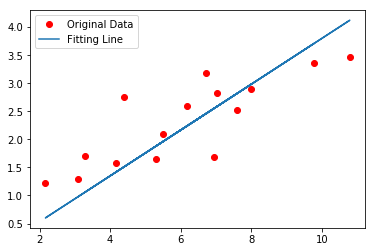

In [7]:
# 5.评估模型性能
# %pylab    
model.eval()                     # 模型变成测试模式
model.cpu()
predict = model(inputs)          # 对输入数据的输出进行预测
predict = predict.data.numpy()   # 转换为numpy数据才可以画图
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data')
# 是一条直线，所以顺序不会影响绘图
plt.plot(x_train.numpy(), predict, label='Fitting Line')  
plt.legend(['Original Data', 'Fitting Line'])
plt.show()

小结:
1. 创建数据或数据的读取及预处理
2. 构建网络模型
3. 实例化模型并定义损失函数及优化方法
4. 读入数据训练网络，同时输出准确率的验证结果
5. 测试模型的性能并可视化

### 1.2 多项式回归
每一维特征属性的次数不唯一

In [8]:
# 1.数据的创建和预处理
def make_features(x):
    """使数据X处理为多项式矩阵[x, x^2, x^3]"""
    x =x.unsqueeze(1)            # 参数1变为列向量，参数0变为行向量
    # 拼接的是tensor组成的列表，1表示按列拼接，0表示按行拼接 (0行1列)
    return torch.cat([x**i for i in range(1,4)], 1)   # 按列拼接为矩阵
# 使数据满足y=0.9+0.5*x+3*x^2+2.4*x^3关系，向量化为y = X*W + b
w_target = torch.Tensor([0.5, 3, 2.4]).unsqueeze(1)   # 权重变为列向量
b_target = torch.Tensor([0.9])
def func(x):    # 构建函数关系式
    return x.mm(w_target) + b_target    # y = X*W + b，得到列向量

test = torch.Tensor([1,2,3,4,5,6,7])
test_out = make_features(test)
print('1.拼接后的矩阵:\n', test_out)
out = func(test_out)
print('2.满足多项式的输出:\n', out)

1.拼接后的矩阵:
 tensor([[   1.,    1.,    1.],
        [   2.,    4.,    8.],
        [   3.,    9.,   27.],
        [   4.,   16.,   64.],
        [   5.,   25.,  125.],
        [   6.,   36.,  216.],
        [   7.,   49.,  343.]])
2.满足多项式的输出:
 tensor([[   6.8000],
        [  33.1000],
        [  94.2000],
        [ 204.5000],
        [ 378.4000],
        [ 630.3000],
        [ 974.6000]])


In [9]:
# 上述函数合并为一个process_data
def process_data(input_x):           # 预处理数据
    input_x = input_x.unsqueeze(1)   # 得到列向量
    concat_x = torch.cat([input_x**i for i in range(1,4)], 1)  # 按列拼接为矩阵
    w_target = torch.Tensor([0.5, 3, 2.4]).unsqueeze(1)        # 权重变为列向量
    b_target = torch.Tensor([0.9])
    output_y = concat_x.mm(w_target) + b_target                # 使数据符合多项式
    return concat_x, output_y
# test = torch.Tensor([1,2,3,4,5,6,7])
# x, y = process_data(test)
def get_batch(batch_size=32):      # 返回batch_size的(x,y)数据对用于训练
    random_data = torch.randn(batch_size)            # 随机产生高斯分布的数据
    x_train, y_train = process_data(random_data)     # 产生符合要求的数据
    inputs, target = (Variable(x_train).cuda(), Variable(y_train).cuda()) \
                if torch.cuda.is_available() \
                else (Variable(x_train), Variable(y_train))
    return inputs, target

In [10]:
# 2.构建模型并定义损失函数及优化方法
# 定义模型
class poly_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.poly = nn.Linear(3,1)   # y = X*W + b, x为3维，y为1维
    def forward(self, x):
        return self.poly(x)
model = poly_model().cuda() if torch.cuda.is_available() else poly_model()
# 定义损失函数与优化方法
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [11]:
# 3.训练模型
epoch = 0
while True:
    batch_x, batch_y = get_batch()       # 获取数据
    output = model(batch_x)              # 前向传播
    loss = criterion(output, batch_y)    # 计算损失函数
    print_loss = loss.data[0]
    optimizer.zero_grad()                # 梯度归零
    loss.backward()                      # 误差反向传播
    optimizer.step()                     # 更新参数
    epoch += 1        
    if print_loss < 1e-3:
        break
    if epoch % 100 == 0:
        print('Epoch[{}], loss: {:.6f}'.format(epoch+1, print_loss))

Epoch[101], loss: 6.727279
Epoch[201], loss: 3.678730
Epoch[301], loss: 0.678043
Epoch[401], loss: 0.451646
Epoch[501], loss: 0.125422


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


Epoch[601], loss: 0.069808
Epoch[701], loss: 0.075340
Epoch[801], loss: 0.045415
Epoch[901], loss: 0.053066
Epoch[1001], loss: 0.058583
Epoch[1101], loss: 0.033587
Epoch[1201], loss: 0.026736
Epoch[1301], loss: 0.024441
Epoch[1401], loss: 0.022915
Epoch[1501], loss: 0.015074
Epoch[1601], loss: 0.012988
Epoch[1701], loss: 0.010690
Epoch[1801], loss: 0.008125
Epoch[1901], loss: 0.012129
Epoch[2001], loss: 0.004535
Epoch[2101], loss: 0.006193
Epoch[2201], loss: 0.005225
Epoch[2301], loss: 0.004225
Epoch[2401], loss: 0.003014
Epoch[2501], loss: 0.003235
Epoch[2601], loss: 0.002025


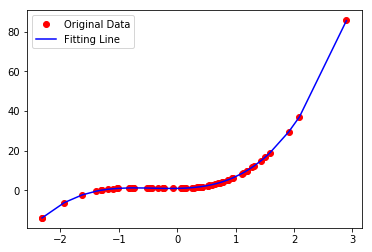

In [12]:
# 4.评估模型性能
# %pylab    
model.eval()                     # 模型变成测试模式
model.cpu()
test_x, test_y = get_batch(64)
predict = model(test_x)          # 对输入数据的输出进行预测
predict = predict.data.numpy()   # 转换为numpy数据才可以画图
test_x = test_x[:,0].unsqueeze(1)
plt.plot(test_x.numpy(), test_y.numpy(), 'ro', label='Original Data')
# 由于数据大小顺序是乱的，故无法画出曲线？？？
# plt.plot(test_x.numpy(), predict, 'b.',label='Fitting Data')
plt_data = np.concatenate((test_x.numpy(), predict), axis=1)
# 将数据按第一行排序后绘制直线
plt_data = plt_data[plt_data[:,0].argsort()]
plt.plot(plt_data[:,0], plt_data[:,1], 'b-', label='Fitting Line')
plt.legend()
plt.show()

## 2 分类问题

### 2.1 Logistic回归
Logistic回归中，输出y=1的对数概率是x的线性函数：

1. 拟合决策边界(线性或多项式都行)
2. 建立决策边界和分类概率的关系，得到分类概率

In [13]:
import torch
import numpy as np
from torch import nn, optim
%pylab inline
import matplotlib.pyplot as plt
from torch.autograd import Variable

Populating the interactive namespace from numpy and matplotlib


D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


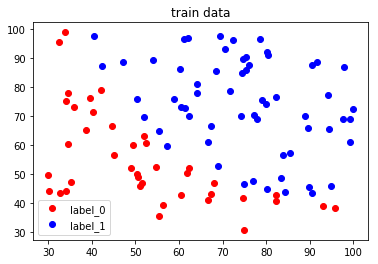

In [14]:
# 1.读取数据
def get_data(file_name):
    with open(file_name) as file:
        data_list = file.read().split('\n')     # 使用readlines会包含回车符
        # 使用map函数将子列表的每个元素转换为float
        data_list = [list(map(float, row.split(','))) for row in data_list]
        # 使用filter函数过滤数据，两类数据分开
        label0 = np.array(list(filter(lambda x: x[-1]==0, data_list)))
        label1 = np.array(list(filter(lambda x: x[-1]==1, data_list)))
    x0, y0 = label0[:, 0], label0[:, 1]
    x1, y1 = label1[:, 0], label1[:, 1]
    plt.plot(x0, y0, 'ro', label='label_0')
    plt.plot(x1, y1, 'bo', label='label_1')
    plt.legend(loc='best')
    plt.title('train data')
    plt.show()
    
    x_train = np.concatenate((label0[:,:2], label1[:, :2]), axis=0)  # 按行拼接
    y_train = np.array([0]*label0.shape[0] + [1]*label1.shape[0])    # 构建label
    data_train = np.concatenate((x_train, y_train[:,np.newaxis]), axis=1)
#     print(data_train)
    return data_train        # 返回 numpy格式的训练数据
mydata = get_data('data.txt')

In [15]:
# 产生训练模型的batch数据
import random
def get_batch(data, batch_size=100):                     # 生成数据的迭代器
    """data:特征+标签的numpy数据
       batch_size:批次的大小
       返回批次训练数据的生成器"""
    train_data = data
    order = list(range(len(train_data)))
    random.shuffle(order)               # shuffle作用于多维数组会出现重复的行！！！
    train_data = train_data[order]
    index = 0
#     print(type(data))
    while True:
        if index + batch_size < len(train_data):
            total_data = train_data[index: index+batch_size] # 按照行访问数据
            index += batch_size
        else:
            total_data = train_data[index:] 
            index = 0 
        yield total_data[:, :2], total_data[:, -1:]
g = get_batch(mydata)

In [16]:
test_x, test_y = next(g)
# print(test_x)
print(test_x.shape)
print(test_y.shape)

(100, 2)
(100, 1)


In [17]:
# 2.定义模型、损失函数及优化方法
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)   # 模型两个特征，一个输出
        self.sigm   = nn.Sigmoid()
    def forward(self, x):
        x = self.linear(x)
        out = self.sigm(x)
        return out
logistic_model = LogisticRegression().cuda() if torch.cuda.is_available() \
                 else LogisticRegression()
criterion = nn.BCELoss()
optimizer = optim.SGD(logistic_model.parameters(), lr=1e-3, momentum=0.9)

**BCELoss()**

定义: $loss(o,t)=\frac{1}{n}\sum_i{(t_i \cdot log(o_i)+(1-t_i) \cdot log(1-o_i))}$

In [18]:
# 3.训练网络
num_epochs = 50000
gen = get_batch(mydata, batch_size=100)
for epoch in range(num_epochs):
    x, y = next(gen)
    x, y = map(torch.Tensor, (x,y))    # 将x，y转换为张量
    x_train, y_train = (Variable(x).cuda(), Variable(y).cuda()) \
                       if torch.cuda.is_available() \
                       else (Variable(x), Variable(y))  # 转换为Variable
    # 前向传播
    out = logistic_model(x_train)     # 计算输出
    loss = criterion(out, y_train)    # 计算损失函数
    print_loss = loss.data[0]         # 获取损失函数的值
    mask = out.ge(0.5).float()        # 大于0.5的设置为1，否则设置为0
    correct = (mask == y_train).sum()     # 统计预测正确的个数，这里得到整型tensor
#     print(correct.dtype)
    # 必须转换为numpy运算才行
    acc = correct.data[0].numpy() / y_train.shape[0]   # 计算准确率size(0)
#     print(acc)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 输出验证的结果
    if (epoch + 1) % 10000 == 0:
        print('-'*10)
        print('epoch {}'.format(epoch+1))
        print('loss is {:.4f}'.format(print_loss))
        print('acc is {:.4f}'.format(acc))

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


----------
epoch 10000
loss is 16.5786
acc is 0.4000
----------
epoch 20000
loss is 16.5786
acc is 0.4000
----------
epoch 30000
loss is 16.5786
acc is 0.4000
----------
epoch 40000
loss is 16.5786
acc is 0.4000
----------
epoch 50000
loss is 16.5786
acc is 0.4000


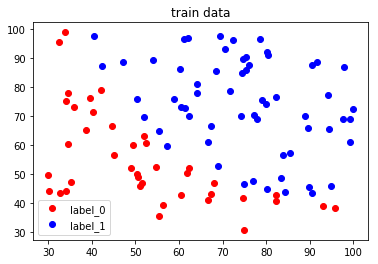

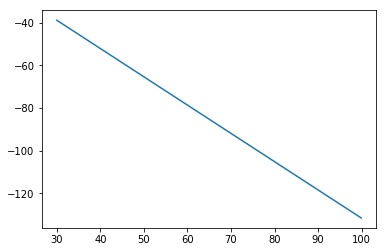

In [19]:
# 4.绘制拟合曲线
mydata = get_data('data.txt')
w0, w1 = logistic_model.linear.weight[0]      # 模型得到的变量均为Variable类型
w0, w1 = w0.data.numpy(), w1.data.numpy()
b = logistic_model.linear.bias.data.numpy()
plot_x = np.arange(30, 100, 0.1)
plot_y = (-w0 * plot_x - b) / w1
plt.plot(plot_x, plot_y)

小结:
- random.shuffle()处理一维的列表和numpy数组时只是打乱顺序，但在处理多维numpy数组时，该函数会将数组的行随机的重复，所以要格外注意
- 在PyTorch中，在计算数值时最好转换到相同的格式，如都是numpy格式或tensor格式，防止出错
- 在PyTorch中，注意IntTensor()数据运算的'/'符号被认为整除符号，转换为float型计算除法

In [20]:
# numpy数组排序
a = np.array([[1,3,2,0,5],[2, 4,3,1,6], [0, 2, 1, -1, 4]])
data = np.array(a)
print('1.原数据:\n', data)
print('2.按第3列排序:\n', data[data[:,2].argsort()] )  # 按第3列排序
print('3.按第2行排序:\n', data[:,data[1].argsort()])   # 按第2行排列

1.原数据:
 [[ 1  3  2  0  5]
 [ 2  4  3  1  6]
 [ 0  2  1 -1  4]]
2.按第3列排序:
 [[ 0  2  1 -1  4]
 [ 1  3  2  0  5]
 [ 2  4  3  1  6]]
3.按第2行排序:
 [[ 0  1  2  3  5]
 [ 1  2  3  4  6]
 [-1  0  1  2  4]]
